<a href="https://colab.research.google.com/github/damar3c50/forecast-with-arima/blob/main/Forecast_JKSE_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARIMA JKSE

In [ ]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
Mounted at /content/drive


###ARTO

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/^JKSE.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1541 non-null   object 
 1   Open       1508 non-null   float64
 2   High       1508 non-null   float64
 3   Low        1508 non-null   float64
 4   Close      1508 non-null   float64
 5   Adj Close  1508 non-null   float64
 6   Volume     1508 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.4+ KB


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,6366.083008,6445.910156,6326.092773,6339.237793,6339.237793,52168200.0
1,2018-01-03,6341.270996,6342.190918,6220.694824,6251.479004,6251.479004,48866400.0
2,2018-01-04,6257.716797,6292.320801,6233.937012,6292.320801,6292.320801,57864900.0
3,2018-01-05,6279.457031,6353.737793,6278.724121,6353.737793,6353.737793,74223700.0
4,2018-01-08,6354.361816,6385.403809,6349.041992,6385.403809,6385.403809,66702400.0


In [ ]:
df.isnull().sum()

Date          0
Open         33
High         33
Low          33
Close        33
Adj Close    33
Volume       33
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

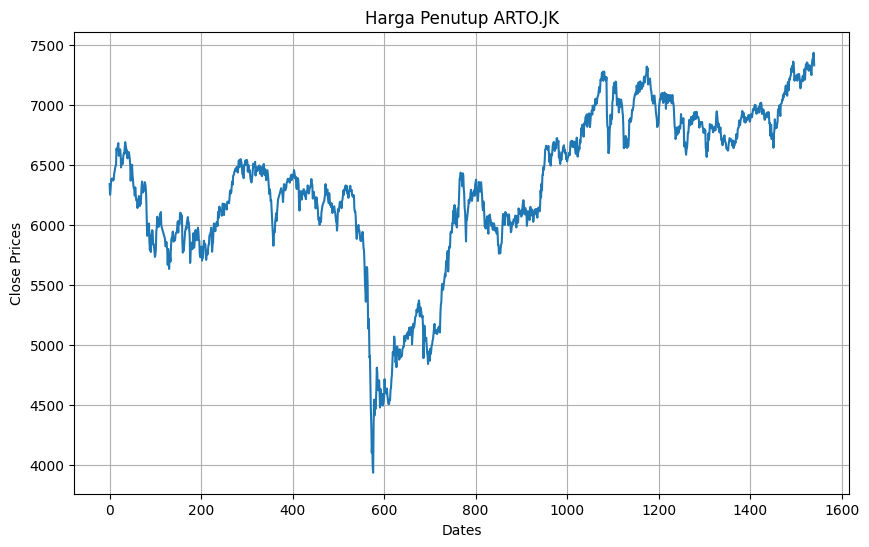

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Harga Penutup ARTO.JK')
plt.show()

<Axes: ylabel='Density'>

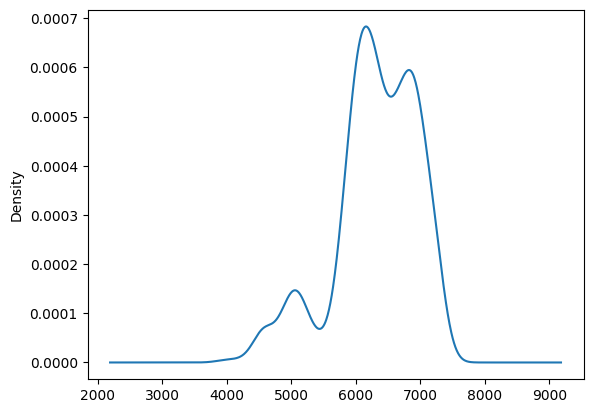

In [ ]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')

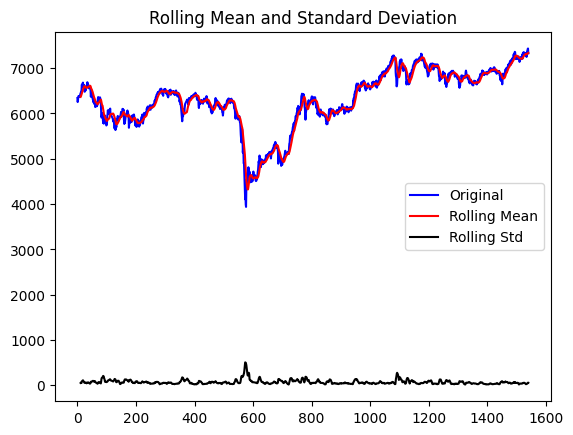

Results of dickey fuller test
Test Statistics                  -1.442571
p-value                           0.561706
No. of lags used                  3.000000
Number of observations used    1504.000000
critical value (1%)              -3.434705
critical value (5%)              -2.863464
critical value (10%)             -2.567794
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

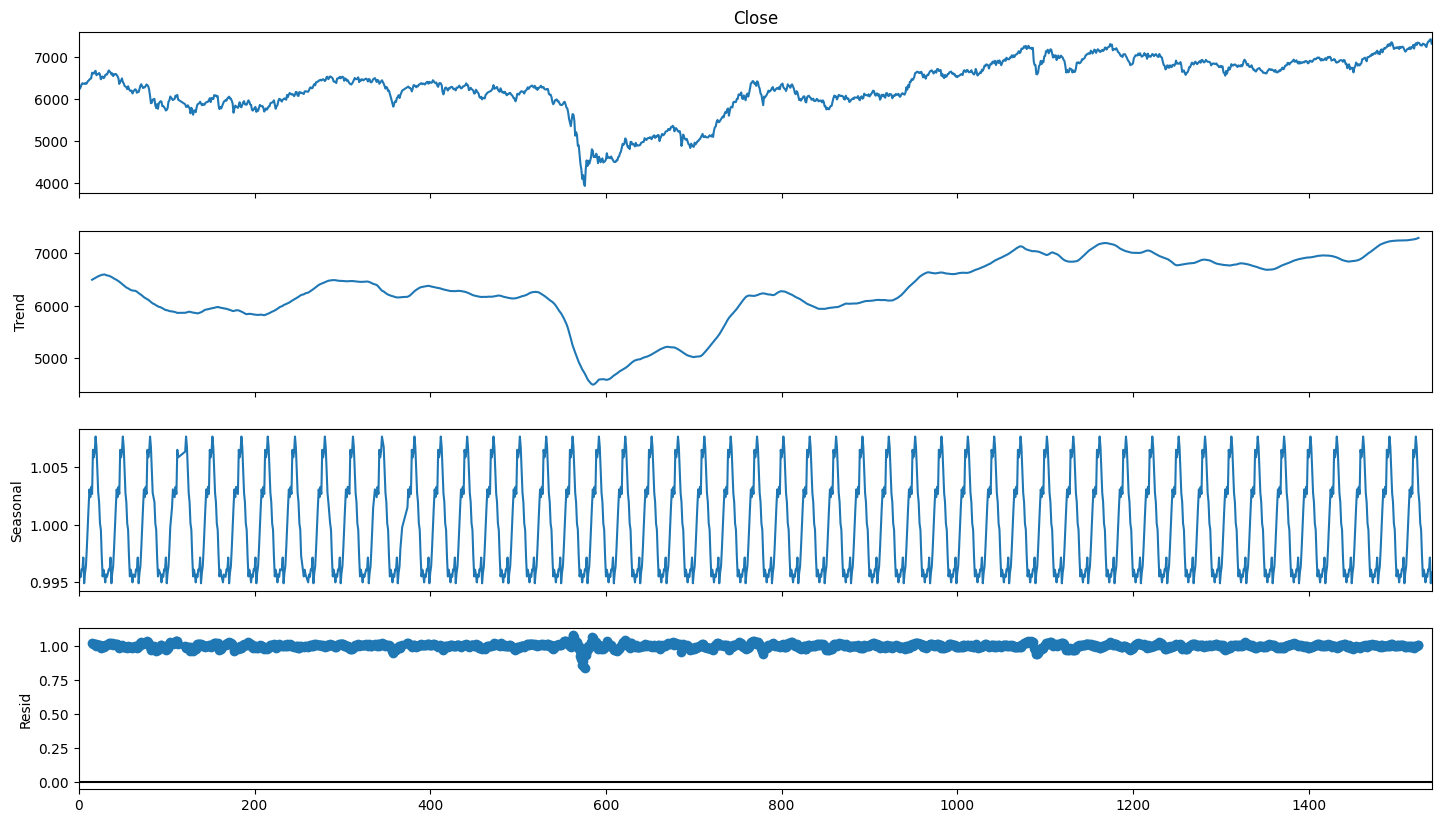

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

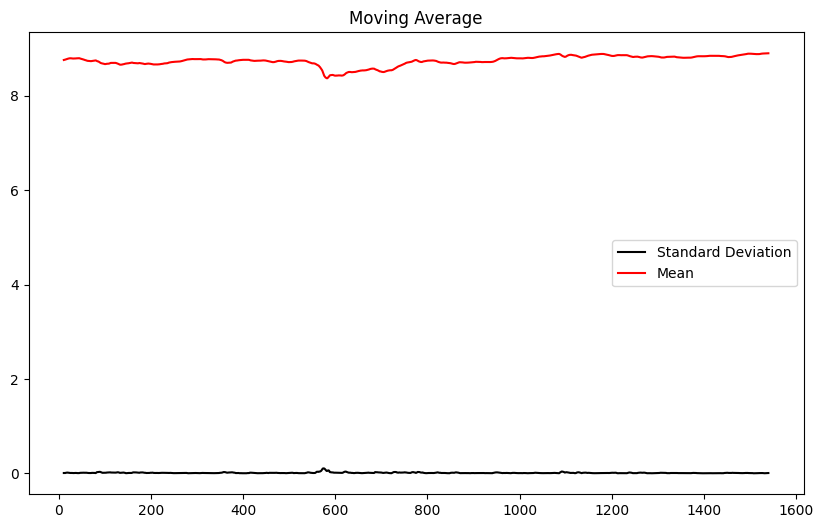

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


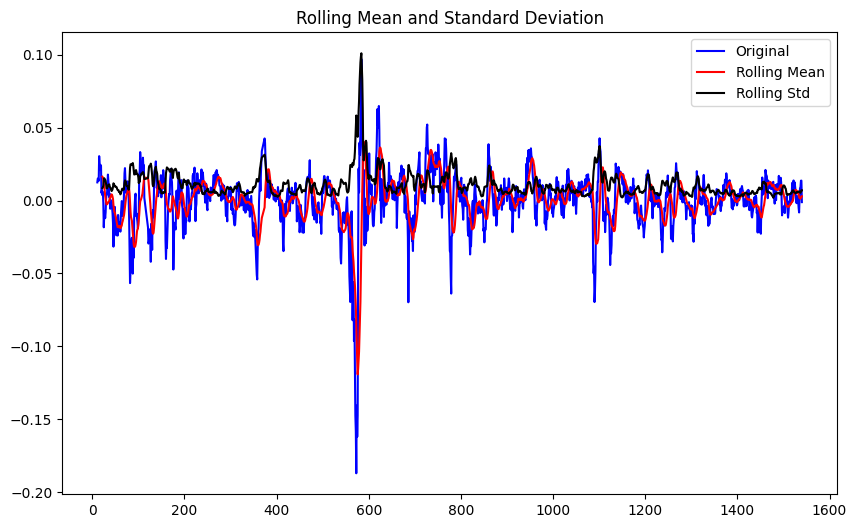

Results of dickey fuller test
Test Statistics               -6.871082e+00
p-value                        1.515080e-09
No. of lags used               2.000000e+01
Number of observations used    1.476000e+03
critical value (1%)           -3.434788e+00
critical value (5%)           -2.863500e+00
critical value (10%)          -2.567814e+00
dtype: float64


In [ ]:
df_log_min_mean = df_log - moving_avg
df_log_min_mean.dropna(inplace=True)

test_stationarity(df_log_min_mean)

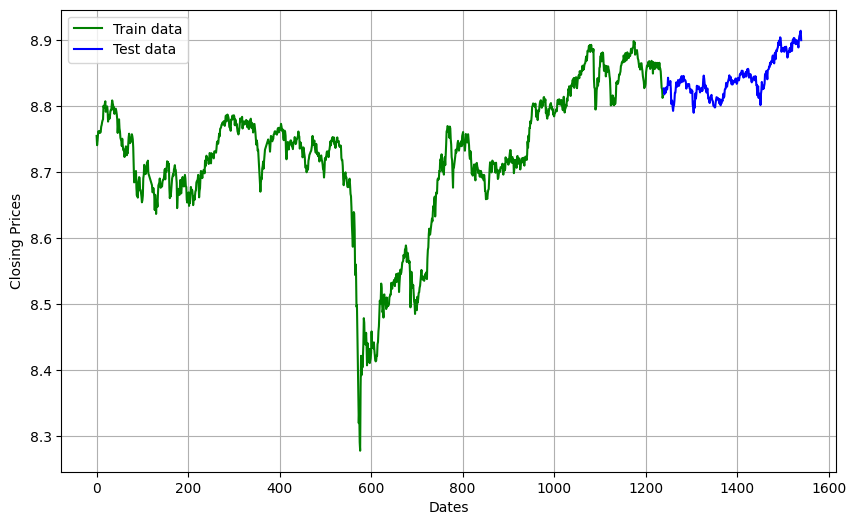

In [ ]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_close)*0.80)], df_log[int(len(df_close)*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7491.864, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7490.690, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7490.778, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7493.837, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7487.864, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.363 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1206
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3747.919
Date:                Sun, 17 Mar 2024   AIC                          -7493.837
Time:                        06:03:28   BIC                          -7488.743
Sample:                             0   HQIC                         -7491.919
                               - 1206                                  

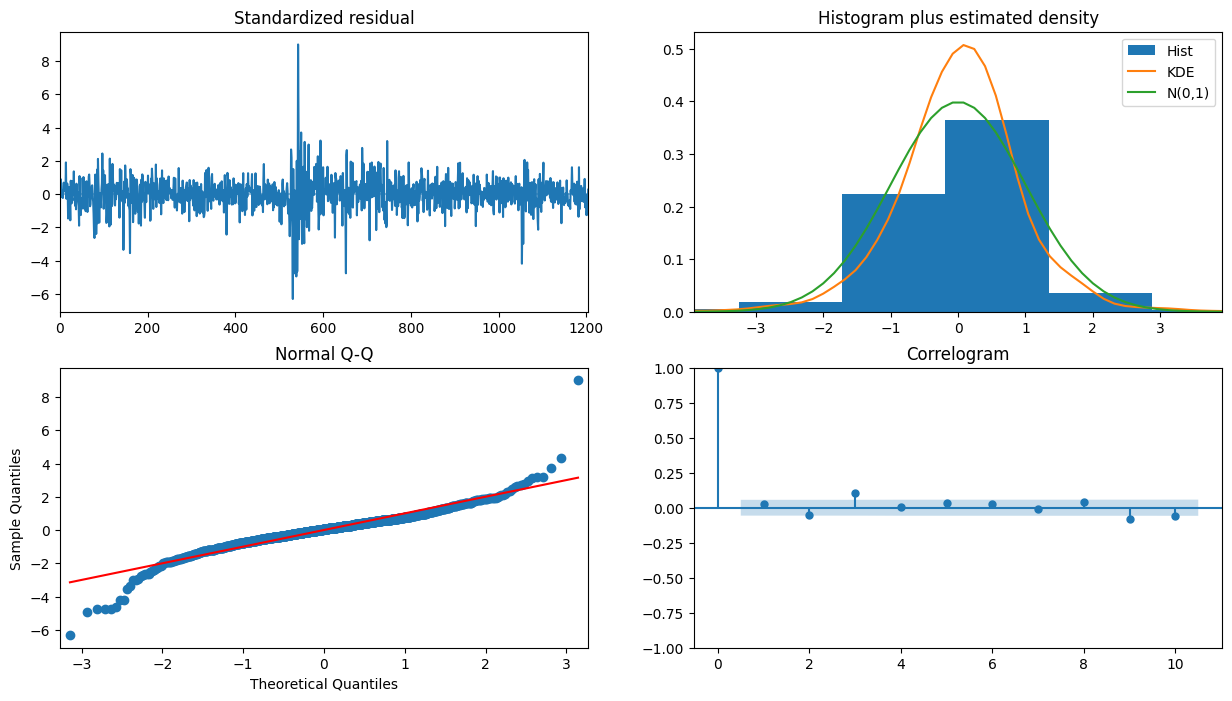

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling
# Build Model
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(0,1,0))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1206
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3747.919
Date:                Sun, 17 Mar 2024   AIC                          -7493.837
Time:                        06:03:39   BIC                          -7488.743
Sample:                             0   HQIC                         -7491.919
                               - 1206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   1.99e-06     58.412      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):              4355.12
Prob(Q):                              0.36   Pr

In [ ]:
train_data.shape

(1206,)

In [ ]:
test_data.shape

(302,)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


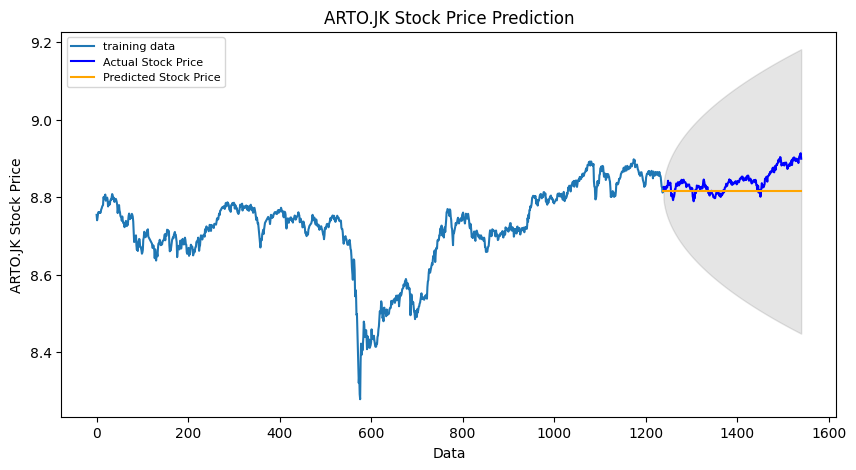

In [ ]:
# Assuming fitted is your time series forecasting model
result = fitted.get_forecast(302, alpha =0.05).summary_frame()

# Assuming result is your predicted values
fc_series = pd.Series(result['mean'].values, index=test_data.index)
lower_series = pd.Series(result['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(result['mean_ci_upper'].values, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('ARTO.JK Stock Price Prediction')
plt.xlabel('Data')
plt.ylabel('ARTO.JK Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0015618055893302318
MAE: 0.030289592842726892
RMSE: 0.03951968609857917
MAPE: 0.003416706659382002
